# Логистическая регрессия
## Задание
Снова про болезни, на этот раз про рак груди. Нужно научиться предсказывать, является ли клеточное образование злокачественным или нет.
## Цель
1. Скачайте данные с Kaggle - https://www.kaggle.com/uciml/breast-cancer-wisconsin-data#data.csv
1. Как всегда - базовые статистики, визуализации (распределения, корреляции, pair-plots). В тех графиках, которые это позволяют, раскрасьте значения в зависимости от того, является опухоль злокачественной или нет.
1. Как вы помните, логистическая регрессия плохо относится к линейно-зависимым признакам, во время предобработки, уберите переменные, корреляция пирсона между которыми превышает 0.85. Разбейте данные на train-test, отложив 30% выборки для тестирования. Приведите все непрерывные переменные к одному масштабу при помощи стандартизации.
1. Постройте модель логистической регрессии “из коробки” без настройки параметров. Оцените метрики качества бинарной классификации (accuracy, precision, recall, f1_score), постройте ROC-кривую и посчитайте площадь под ней. Визуализируйте влияние коэффициентов на целевую переменную.
1. Теперь проведите настройку параметра регуляризации C на кросс-валидации (LogisticRegressionCV). Снова оцените результаты и постройте визуализацию влияния коэффициентов на целевую переменную. Сделайте интересные выводы 
Бонусное задание - постройте также модель KNN с настройкой числа соседей на CV. У какой модели качество оказалось выше?

# Imports

In [52]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже знакомый вам пакет для картинок 
import matplotlib as mplt
import seaborn as sns             # ещё один пакет для картинок 
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Define Functions

In [5]:
def corr_feature_detect(data,method='pearson',threshold=0.8):
    
    corrmat = data.corr(method=method)
    corrmat = corrmat.abs().unstack() 
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] 
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            correlated_groups.append(correlated_block)
    return correlated_groups

def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))
    
def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

# EDA

In [19]:
df = pd.read_csv('data/data.csv')  # подгружаем табличку 
print('Размер выборки:', df.shape)                          # смотрим на её размеры 
df.head( ) # Смотрим что лежит в табличке 

Размер выборки: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## 1. Анализ целевой переменной

In [20]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

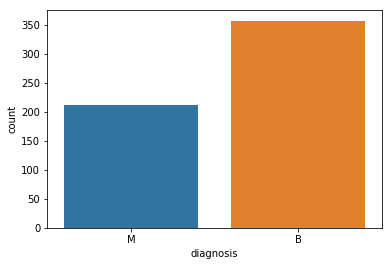

In [21]:
sns.countplot(x='diagnosis',data=df);

Из графика видно, что датасет не сбалансирован.

Приведем целевую переменную к числовому типу:
- M (malignant) = 1
- B (benign) = 0

In [22]:
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## 2. Анализ признаков

Посмотрим сколкьо пропущенных значений содержится в датасете.

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null int64
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-

Признак `Unnamed: 32 ` содержит `0` строк. Выведем данные этого признака:

In [24]:
df['Unnamed: 32'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: Unnamed: 32, dtype: float64

Возможно все значения признака равны `NaN`. Посмотрим сколько датасете `NaN` значений:

In [25]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

Предположение для признака `Unnamed: 32` оказалось верным, количество значений `NaN` для признака составляет 569, что равно размеру датасета. Данный признак исключим из выборки.

In [26]:
df.drop(columns=['Unnamed: 32'],inplace=True)

Построим корреляционную матрицу.

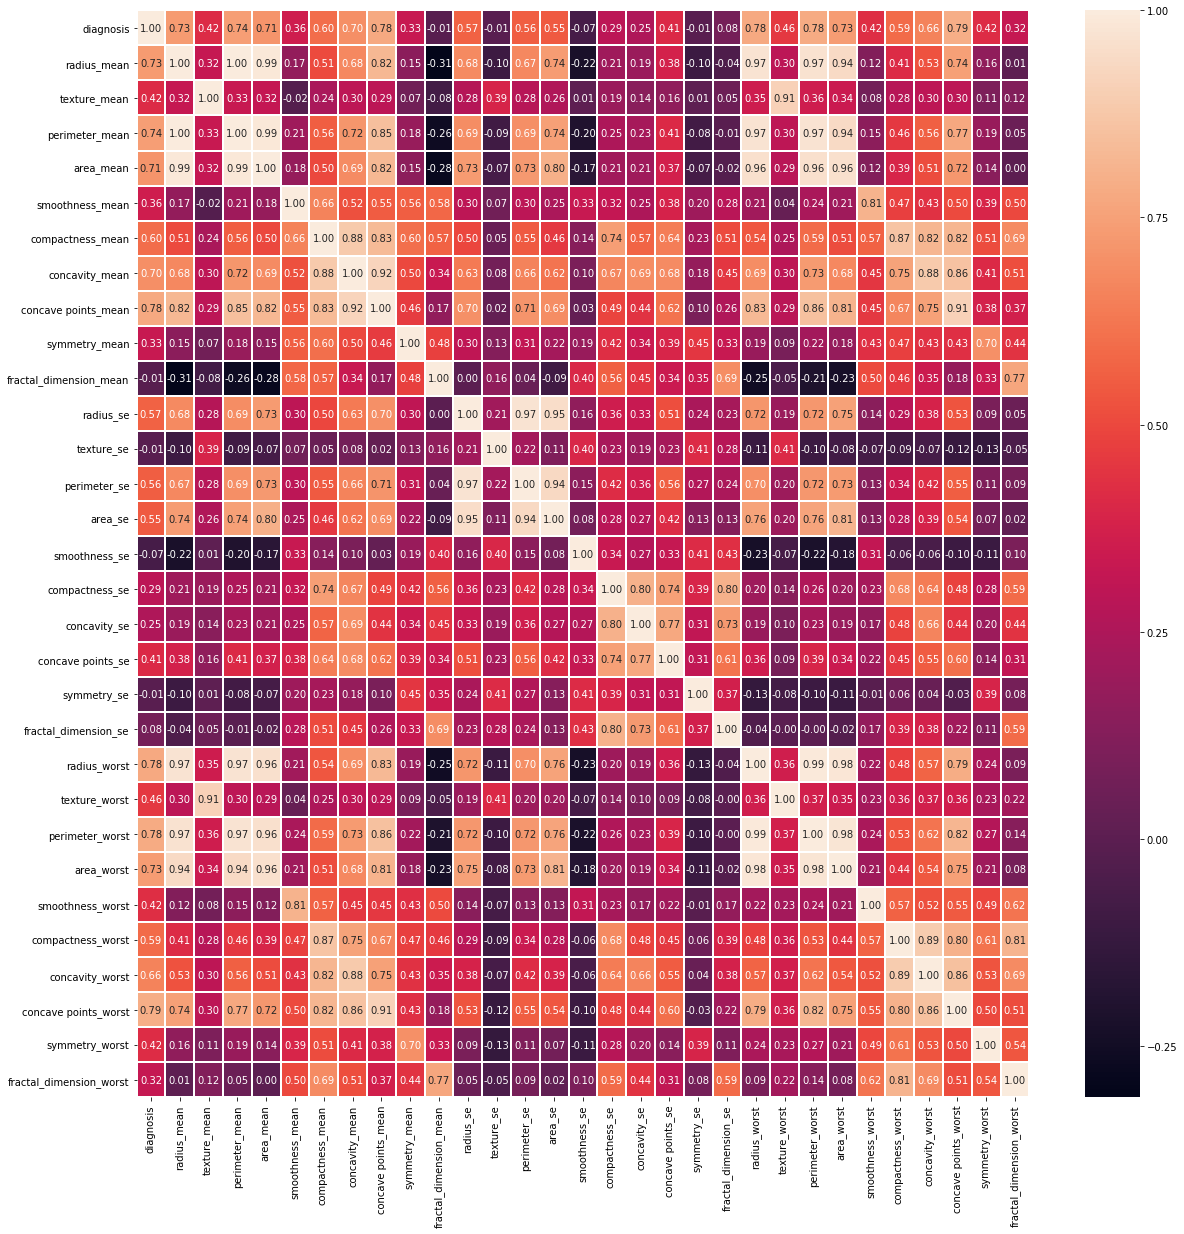

In [27]:
fig, ax = plt.subplots(figsize=(20,20)) 
df_corr = df.drop(columns='id').corr(method='pearson')
sns.heatmap(df_corr, annot=True, fmt='.2f', linewidths=1, ax=ax);

Из матрицы видно, что есть признаки линейно-зависимые признаки, корреляция между которыми близка к 1. Найдем линейно-зависимые признаки с корреляцией выше 0.85.

In [28]:
corr = corr_feature_detect(data=df,threshold=0.85)
for i in corr:
    print(i,'\n')

       feature1         feature2      corr
0   radius_mean   perimeter_mean  0.997855
5   radius_mean        area_mean  0.987357
17  radius_mean     radius_worst  0.969539
20  radius_mean  perimeter_worst  0.965137
33  radius_mean       area_worst  0.941082 

        feature1   feature2      corr
12  perimeter_se  radius_se  0.972794
34  perimeter_se    area_se  0.937655 

          feature1              feature2      corr
36  concavity_mean   concave points_mean  0.921391
45  concavity_mean       concavity_worst  0.884103
46  concavity_mean      compactness_mean  0.883121
50  concavity_mean  concave points_worst  0.861323 

         feature1      feature2      corr
38  texture_worst  texture_mean  0.912045 

             feature1          feature2      corr
42  compactness_worst   concavity_worst  0.892261
49  compactness_worst  compactness_mean  0.865809 



Признаки под наименованием `feature1` включают в себя инфорамцию признаков под наименованием `feature2`.

В выборке оставим признаки: `radius_mean, perimeter_se, concavity_mean, texture_worst`, а признаки `perimeter_mean, area_mean, radius_worst, perimeter_worst, area_worst, radius_se, area_se, concave points_mean, concavity_worst, compactness_mean, concave points_worst, texture_mean` исключим.

In [29]:
drop_columns = [
    'id',
    'perimeter_mean','area_mean','radius_worst','perimeter_worst','area_worst', # radius_mean
    'radius_se','area_se', # perimeter_se
    'concave points_mean', 'concavity_worst', 'compactness_mean', 'concave points_worst', # concavity_mean
    'texture_mean', # texture_worst
]

df.drop(columns=drop_columns, axis=1,inplace=True)

Проверим, что линейно-зависимых признаков не осталось и посмотрим на матрицу корреляций.

In [30]:
corr = corr_feature_detect(data=df,threshold=0.85)
for i in corr:
    print(i,'\n')


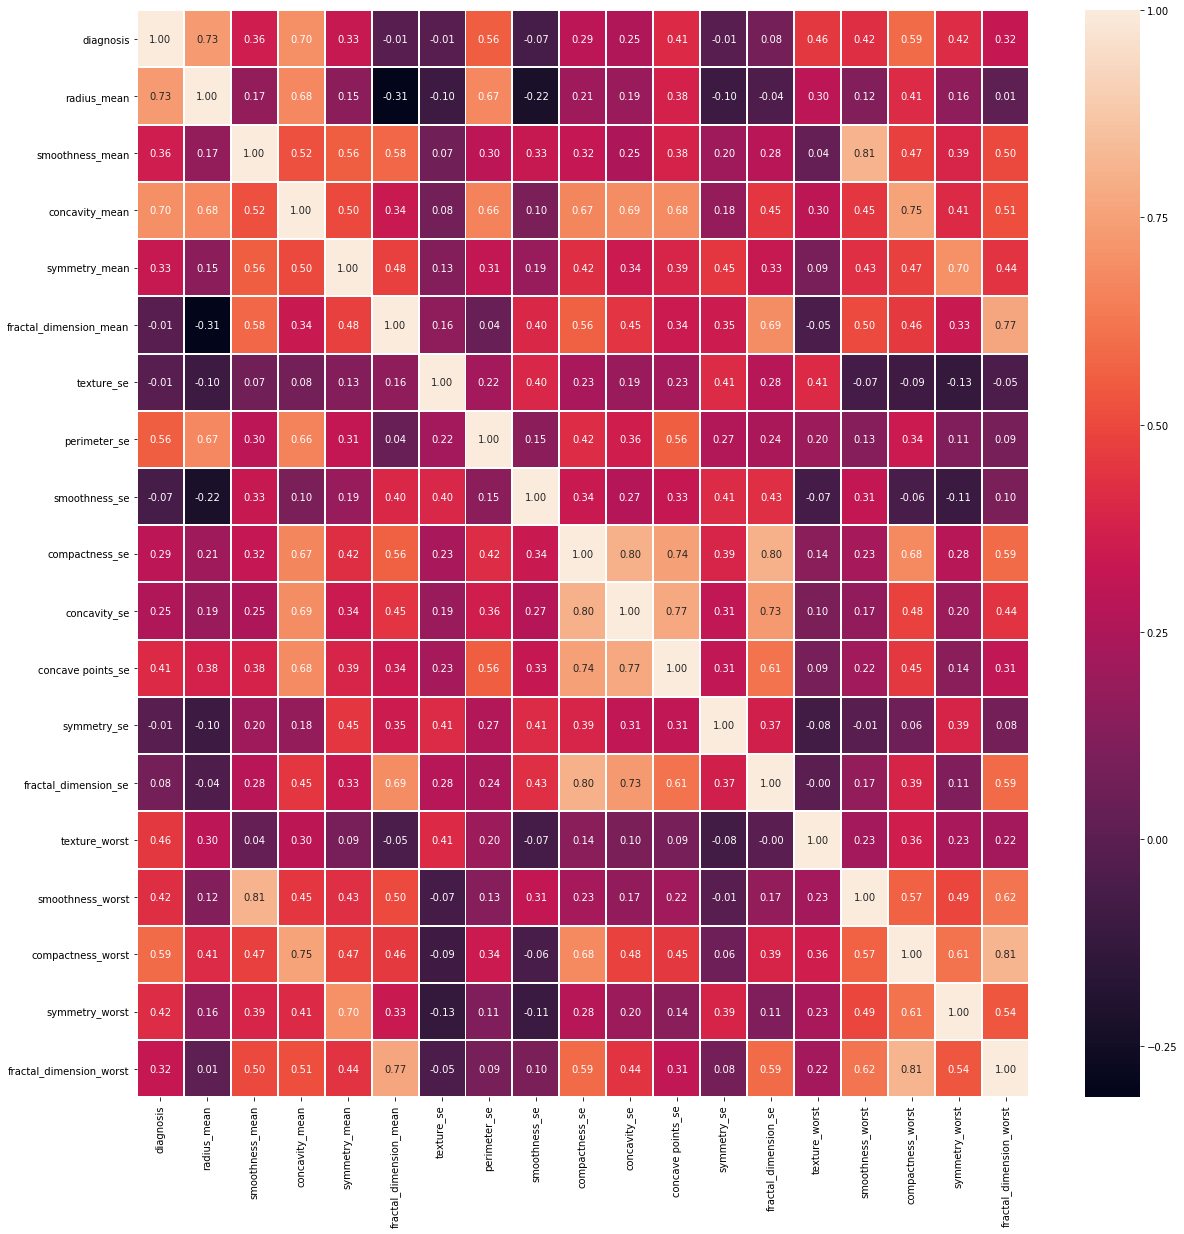

In [31]:
fig, ax = plt.subplots(figsize=(20,20)) 
df_corr = df.corr(method='pearson')
sns.heatmap(df_corr, annot=True, fmt='.2f', linewidths=1, ax=ax);

In [42]:
df.columns

Index(['diagnosis', 'radius_mean', 'smoothness_mean', 'concavity_mean',
       'symmetry_mean', 'fractal_dimension_mean', 'texture_se', 'perimeter_se',
       'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se',
       'symmetry_se', 'fractal_dimension_se', 'texture_worst',
       'smoothness_worst', 'compactness_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')

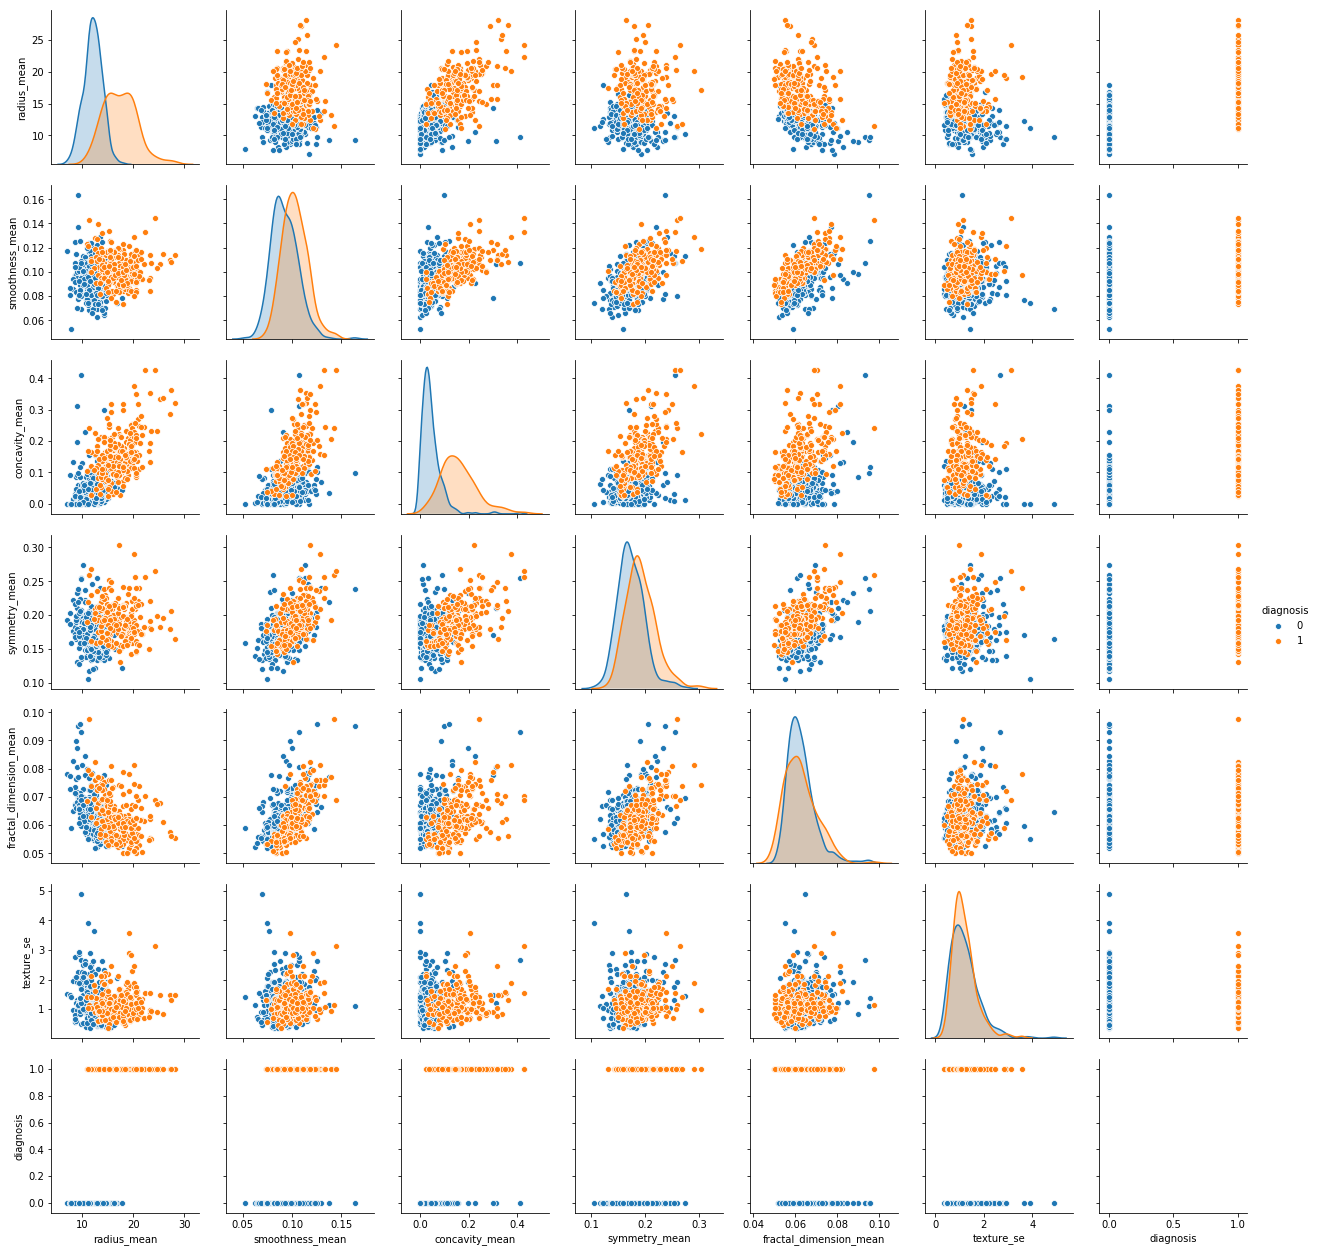

In [45]:
sns.pairplot(data=df[[
    'radius_mean', 'smoothness_mean', 'concavity_mean', 
    'symmetry_mean', 'fractal_dimension_mean', 'texture_se',
    'diagnosis'
]], hue='diagnosis');

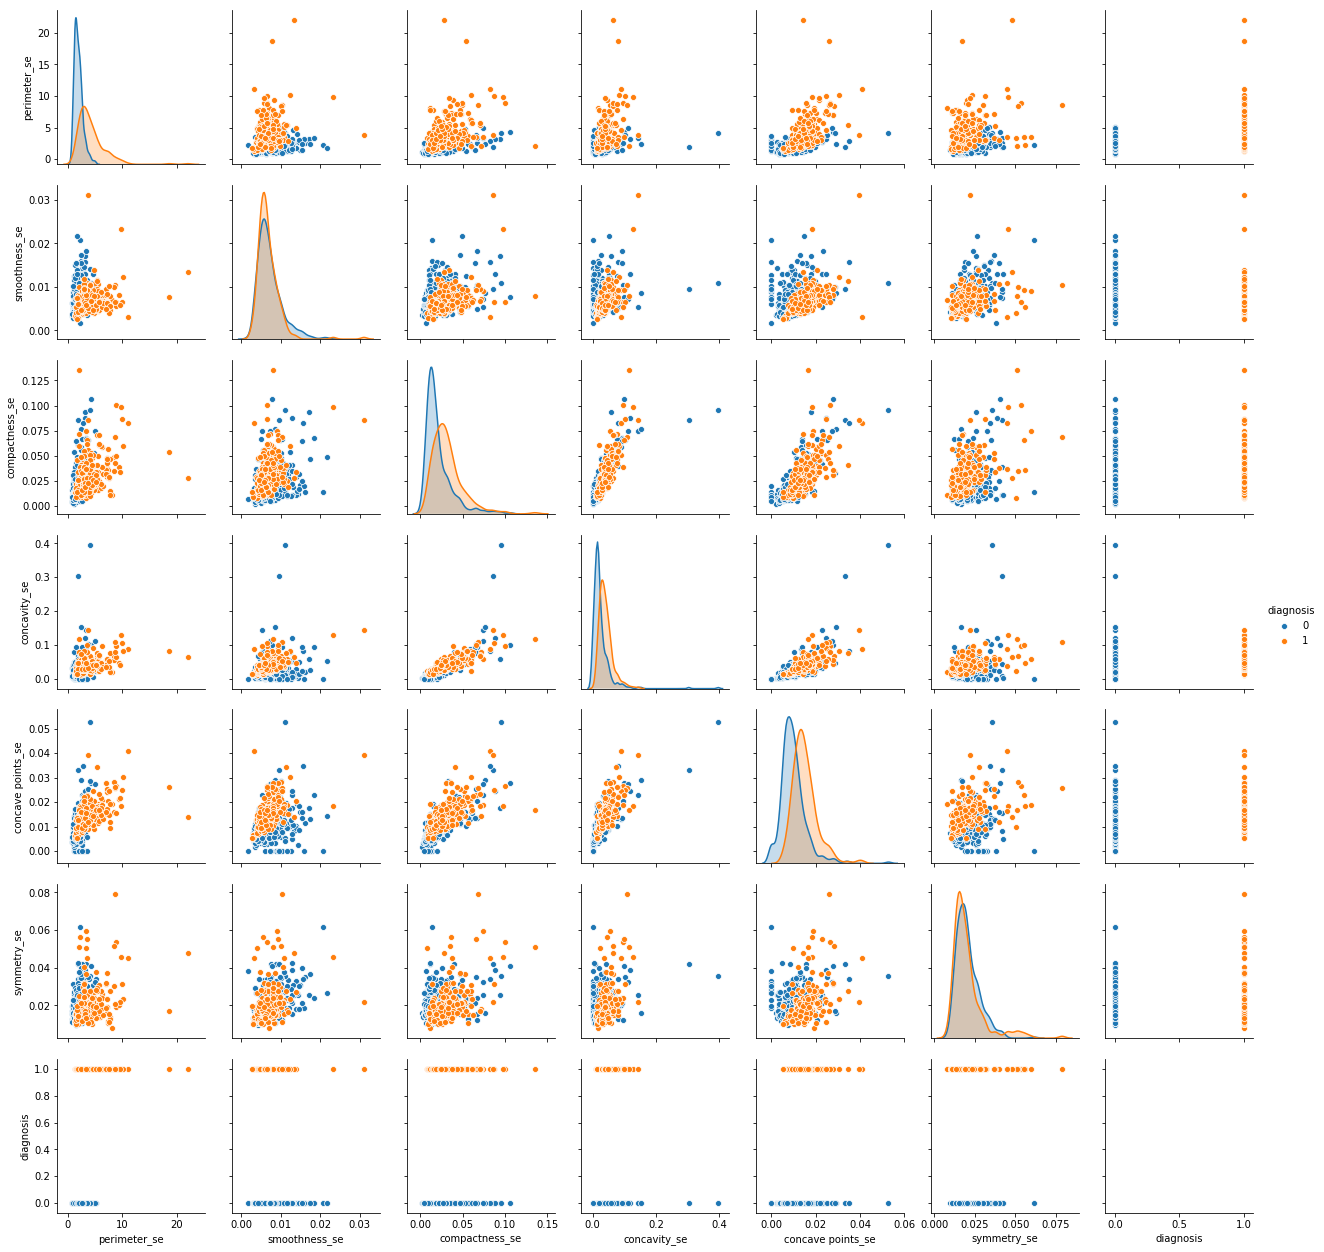

In [46]:
sns.pairplot(data=df[[
    'perimeter_se', 'smoothness_se', 'compactness_se', 
    'concavity_se', 'concave points_se','symmetry_se',
    'diagnosis'
]], hue='diagnosis');

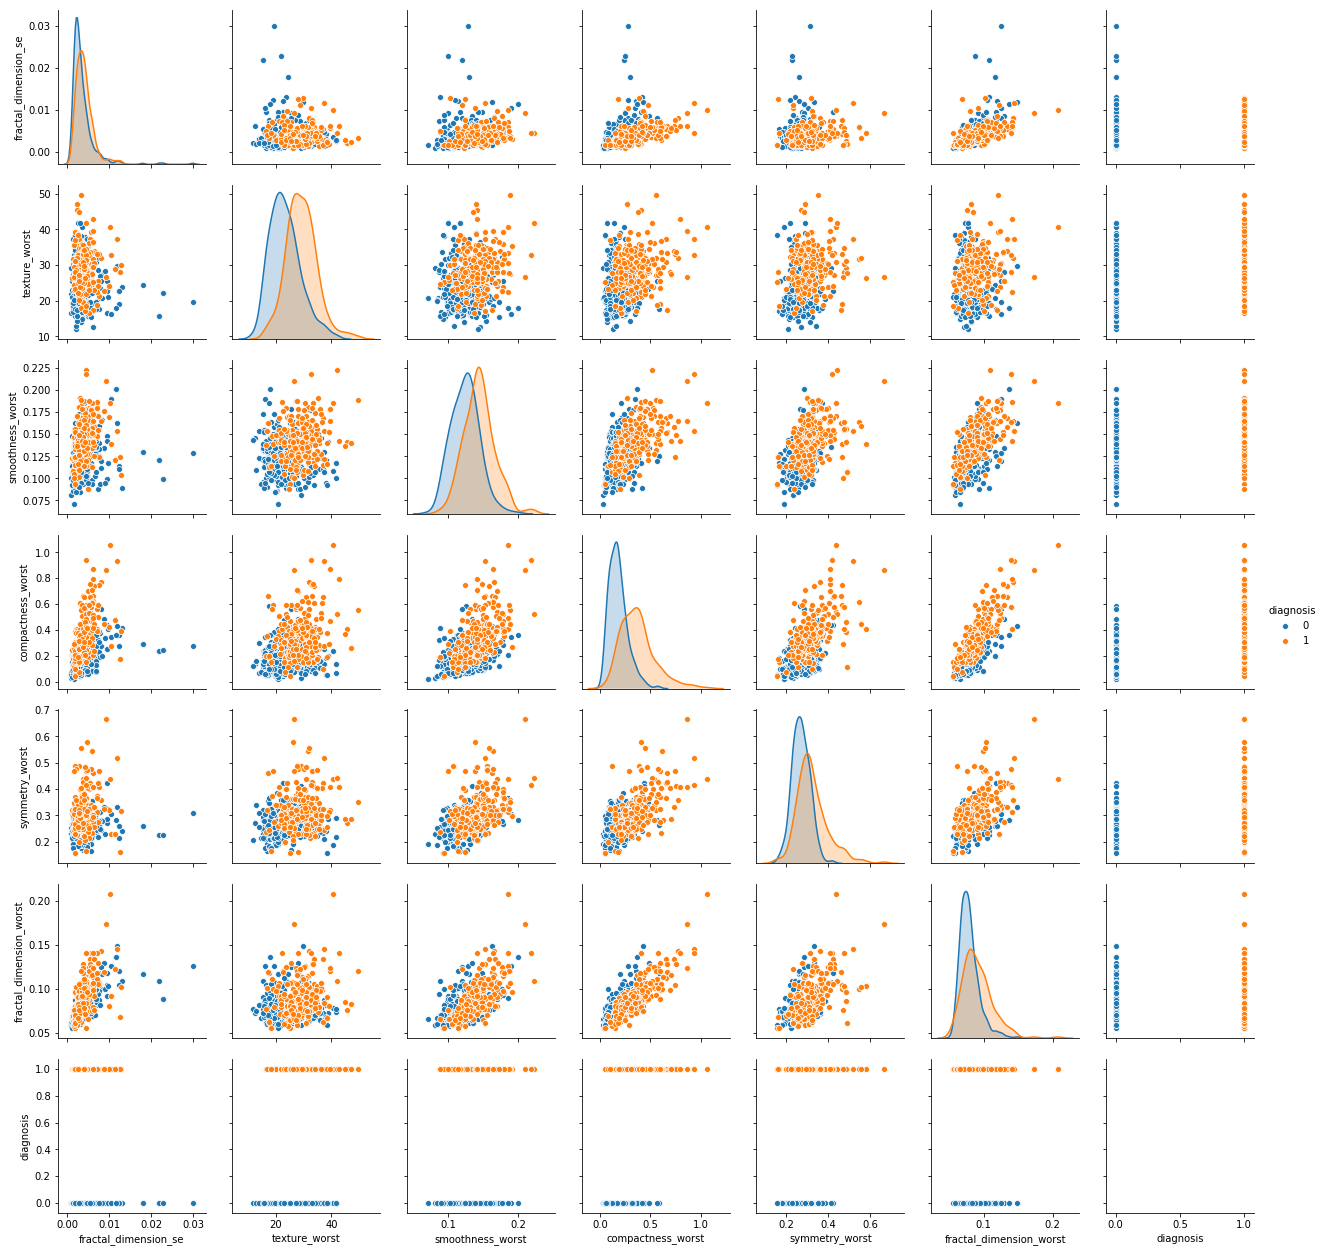

In [48]:
sns.pairplot(data=df[[
    'fractal_dimension_se', 'texture_worst', 'smoothness_worst', 
    'compactness_worst', 'symmetry_worst', 'fractal_dimension_worst',
    'diagnosis'
]], hue='diagnosis');

Анализ графиков показал, что данные линейно-неразделимы.

## Base logistic regression

Разделим выборку на тренировочную и тестовую и проведем шкалирование.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['diagnosis'], axis=1), 
    df['diagnosis'], 
    test_size=0.20, 
    random_state=42, 
    stratify=df['diagnosis']
)

# стандартизируем
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Построим базовую логистическую регрессию.

Train quality:
Accuracy: 0.978
Precision: 0.953
Recall: 0.988
f1_score: 0.970

Test quality:
Accuracy: 0.982
Precision: 0.952
Recall: 1.000
f1_score: 0.976


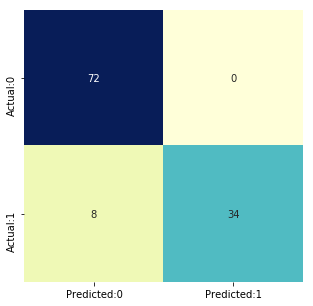

In [55]:
log_reg = LogisticRegression(random_state=42)

log_reg.fit(X_train_scaled, y_train)
print("Train quality:")
quality_report(log_reg.predict(X_train_scaled), y_train)
print("\nTest quality:")
quality_report(log_reg.predict(X_test_scaled), y_test)

cm = confusion_matrix(y_test, log_reg.predict_proba(X_test_scaled)[:, 1]>0.8)
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

Текущая модель имеет отличную долю правильных ответов (Accuracy) - 98.2%. Но определения действительно заболевших раком (Precision) составляет 95.2%, что не очень хорошо. При этом модель на 100% обнаруживет не заболевших раком.
Качество модели смотрим по F-мере, оно составляет 97.6%

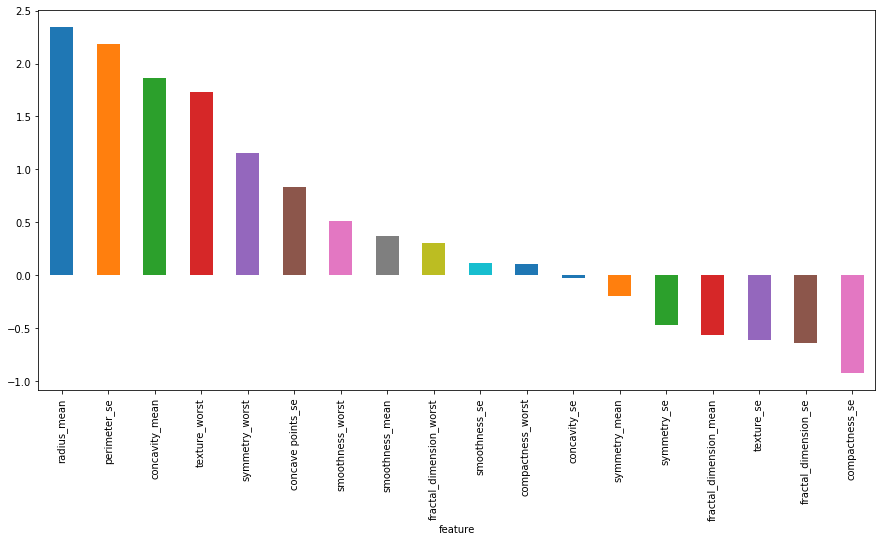

In [19]:
featureImportance = pd.DataFrame({"feature": df.drop('diagnosis',axis=1).columns, 
                                  "importance": log_reg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(15, 7));

Наиболее важными признаками модели являются: `radius_mean` и `compactness_se`.

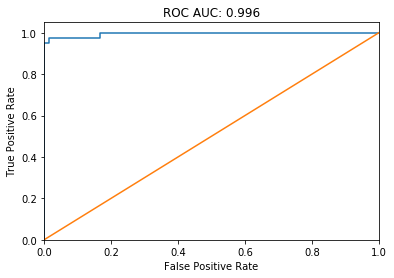

In [20]:
plot_roc_curve(log_reg.predict_proba(X_test_scaled)[:,1], y_test);

## LogisticRegressionCV

Train quality:
Accuracy: 0.982
Precision: 0.965
Recall: 0.988
f1_score: 0.976

Test quality:
Accuracy: 0.956
Precision: 0.905
Recall: 0.974
f1_score: 0.938


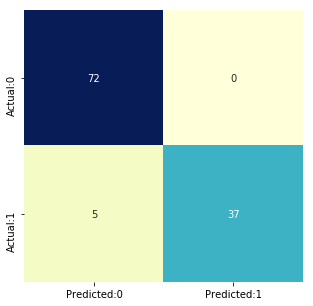

In [64]:
log_reg_cv = LogisticRegressionCV(Cs=100, random_state=42, solver='saga')
log_reg_cv.fit(X_train_scaled, y_train)

print("Train quality:")
quality_report(log_reg_cv.predict(X_train_scaled), y_train)
print("\nTest quality:")
quality_report(log_reg_cv.predict(X_test_scaled), y_test)

cm = confusion_matrix(y_test, log_reg_cv.predict_proba(X_test_scaled)[:, 1]>0.8)
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

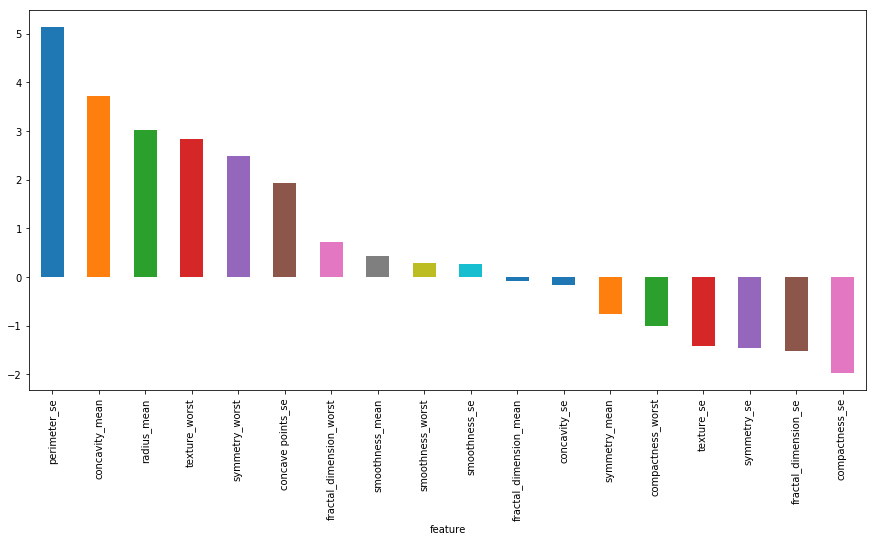

In [31]:
featureImportance = pd.DataFrame({"feature": df.drop('diagnosis',axis=1).columns, 
                                  "importance": log_reg_cv.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(15, 7));

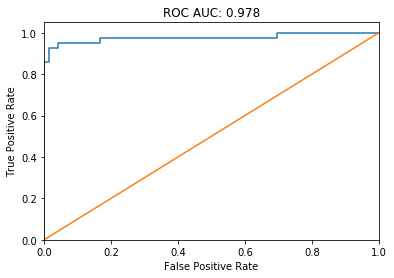

In [32]:
plot_roc_curve(log_reg_cv.predict_proba(X_test_scaled)[:,1], y_test);

Best CV score: 0.935, best CV k: 1

Train quality:
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
f1_score: 1.000

Test quality:
Accuracy: 0.904
Precision: 0.810
Recall: 0.919
f1_score: 0.861


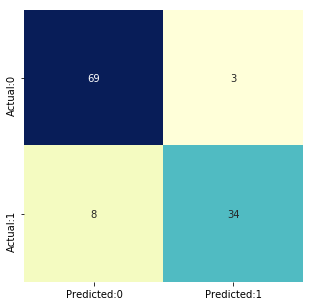

In [59]:
param_grid = {
        'n_neighbors': range(1, 50),
        'p': range(1, 4)
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

print("Best CV score: {:.3f}, best CV k: {}\n".format(
    grid_search.best_score_, grid_search.best_estimator_.n_neighbors)
) 


print("Train quality:")
quality_report(grid_search.best_estimator_.predict(X_train_scaled), y_train)
print("\nTest quality:")
quality_report(grid_search.best_estimator_.predict(X_test_scaled), y_test)

cm = confusion_matrix(y_test, grid_search.best_estimator_.predict_proba(X_test_scaled)[:, 1]>0.8)
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

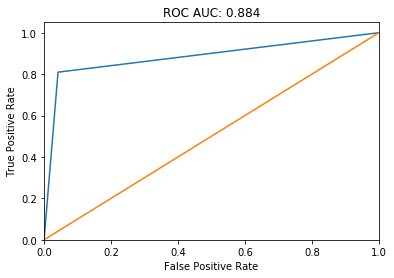

In [60]:
plot_roc_curve(grid_search.best_estimator_.predict_proba(X_test_scaled)[:,1], y_test);

# Вывод

GridSearchCV показал, что наилучший результат был получен при k=1, Тоесть алгоритм k-ближайших соседей свелся к алгоритму ближайшего соседа. Но в данной задаче оказался хуже базовой модели лог. регрессии, так дает ложнополжительные результаты.